In [1]:
import numpy as np
from matplotlib import pyplot as plt
from src.FireFramework import * # importieren des Frameworks
from PIL import Image

# Modelldefinition

In [2]:
def dot(a,b):
    return a[0]*b[0]+a[1]*b[1]

In [3]:
# Liste der pro Zelle zu speichernden Werte
params = ["fuel", "fire", "windx", "windy", "height"]

# Relativvektoren der zu betrachtenen Nachbarn
relative_neighbours = [(-1,0),(1,0),(0,1),(0,-1),(-1,1),(1,1),(-1,-1),(1,-1)] 

In [4]:
def transition(cellState, neighbourStates, returnState):
    
    #Parameter der Nachbarn:
    slope = []
    rel_wind = []
    neighbour_fire = []

    #Vorbereitung der Werte der Nachbarn
    for n in neighbourStates:
        slope.append(np.tanh(n.getParam("height") - cellState.getParam("height")))
        wind = (n.getParam("windx"), n.getParam("windy"))
        rel_wind.append(np.tanh(dot(wind, n.getRelativeVector())))
        neighbour_fire.append(n.getParam("fire"))    

    #Konvertieren zu numpy arrays
    slope = np.array(slope)
    rel_wind = np.array(rel_wind)
    neighbour_fire = np.array(neighbour_fire)

    #Wahrscheinlichkeiten berechnen

    slope_coeff = - np.sum(neighbour_fire * slope)
    wind_coeff = - np.sum(neighbour_fire * rel_wind)
    
    p_burn = 1/8 * np.sum(neighbour_fire) + 0.05 * slope_coeff + 0.1 * wind_coeff
    p_burn *= cellState.getParam("fuel")
    
    p_stop = (1 - cellState.getParam("fuel")) ** 8  #Erlöschen bei wenig Brennwert
    
    #Wahrscheinlichkeiten umsetzen
    
    if p_burn >= np.random.uniform():
        returnState.setParam("fire", 1)
        
    if p_stop >= np.random.uniform():
        returnState.setParam("fire", 0)
        
    returnState.addToParam("fuel", -0.05*cellState.getParam("fire")) # Verringerung des Brennwerts
    if returnState.getParam("fuel") < 0:
        returnState.setParam("fuel", 0)

## Startwerte definieren

In [5]:
def initial_field(row, col):
    fuel = 0.99
    burn = 0
    if row == 20 and col == 20: burn = 1
    
    height = 0
    windx = 1
    windy = 0
    
    return [fuel, burn, windx, windy, height] # Hier der Anfangswert-return

In [6]:
# Hier wird das Gitter erzeugt und die oben definierten Parameter übergeben..
g = Grid(100, 100, params, relative_neighbours, transition, initial_field)

### Modell auswerten

In [7]:
# Nimmt ein numpy-array an welches zb. durch g.runModel() erzeugt wird.
# Zeichnet das Feld auf bekannte Weise unter angabe des zeitindex.
def drawImage(field,index):
    plt.imshow(np.stack([field[index,:,:,1],field[index,:,:,0],np.zeros(shape = (field.shape[1], field.shape[2]))], axis = 2))

In [8]:
# Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
N = 10
result = g.runModel(N)

10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [9]:
total_values = np.sum(result, axis = (1,2))

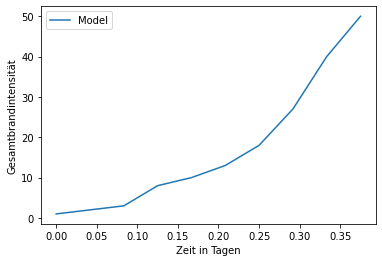

In [10]:
plt.plot(np.arange(N) / 24, total_values[:,1], label = "Model")
plt.xlabel("Zeit in Tagen")
plt.ylabel("Gesamtbrandintensität")
plt.legend()

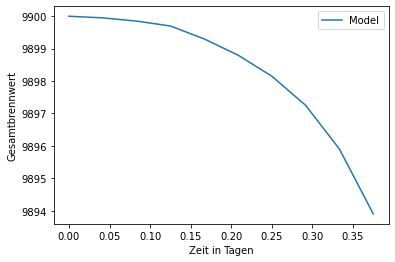

In [11]:
plt.plot(np.arange(N) / 24, total_values[:,0], label = "Model")
plt.xlabel("Zeit in Tagen")
plt.ylabel("Gesamtbrennwert")
plt.legend()

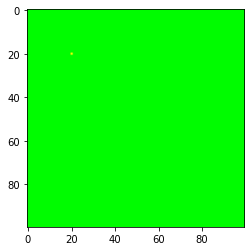

In [12]:
for i in range(int(N/10)):
    drawImage(result, i * 10)